In [1]:
import networkx as nx


In [2]:
from gurobipy import GRB
import fio.layout


G = nx.read_gml("data/micro.gml")

res, work = fio.layout.compute_layers_multi(G, set(), set(), params={GRB.Param.OutputFlag:0})

for u, l in res.items():
    G.nodes[u]["layer"] = l.numerator



Set parameter Username
Set parameter LicenseID to value 2732003
Academic license - for non-commercial use only - expires 2026-11-03
5.0


In [3]:
G1 = G.copy()

for u, v, data in G.edges(data=True):
    if G.nodes[v]["layer"] < G.nodes[u]["layer"]:
        G1.remove_edge(u, v)
        G1.add_edge(v, u, inv=True, **data)

H = G1.copy()

for u, v in G1.edges():
    if (G1.nodes[v]["layer"] - G1.nodes[u]["layer"]) > 1:
        H.remove_edge(u, v)
        dummies = []
        for l in range(G1.nodes[u]["layer"] + 1, G1.nodes[v]["layer"]):
            dummies.append(f"dummy-{l}-{u}--{v}")
            H.add_node(f"dummy-{l}-{u}--{v}", layer=l)
        nx.add_path(H, [u] + dummies + [v])

    if (G1.nodes[u]["layer"] - G1.nodes[v]["layer"]) >= 0:
        assert False

len(H.nodes)/len(G.nodes)

12.28894472361809

In [4]:
layers = {}
for v, data in H.nodes(data=True):
    r = data["layer"]
    layers.setdefault(r, []).append(v)

print({k:len(l) for k, l in sorted(layers.items())})

{0: 91, 1: 542, 2: 787, 3: 846, 4: 618, 5: 508, 6: 356, 7: 343, 8: 275, 9: 274, 10: 156, 11: 92, 12: 3}


In [5]:
import numpy as np
import math

In [6]:
import random

# --- data ---
nodes = list(H.nodes)
N = len(nodes)

pos = nx.spring_layout(H
                    #    , pos={u: (2*data["layer"]/max(layers)-1, 0)for u, data in H.nodes(data=True)}
)


xmin, ymin = np.min(np.vstack(list(pos.values())), axis=0)
xmax, ymax = np.max(np.vstack(list(pos.values())), axis=0)

spanx = xmax - xmin or 1.0
spany = ymax - ymin or 1.0

# grid size from number of nodes
side   = math.sqrt(len(nodes)) * 20
grid_w = math.ceil(side)
grid_h = math.ceil(side)


cell = set()

# rescale in-place
for u in H.nodes:
    x, y = pos[u]

    nodex = int(round((x - xmin) / spanx * (grid_w - 1)))
    nodey = int(round((y - ymin) / spany * (grid_h - 1)))

    step = 1
    dx = 0
    dy = 0
    while (nodex+dx, nodey+dy) in cell or not (0 <= nodex+dx < grid_w) or not (0 <= nodey+dy < grid_h):
        if dx < step and dy == 0:
            dx += 1
        elif dx == step and dy < step:
            dy += 1
        elif dy == step and dx > -step:
            dx -= 1
        elif dx == -step and dy > -step:
            dy -= 1
        if dx == step and dy == step:
            step += 1

    nodex += dx
    nodey += dy
    cell.add((nodex, nodey))

    pos[u] = np.array((nodex, nodey))

from collections import Counter

assert set(Counter(map(tuple, pos.values())).values()) == {1}

def objective(H, pos):
    obj = 0
    for u, v, k in H.edges(keys=True):
        obj += math.sqrt(np.sum((pos[u] - pos[v])**2))
    
    return obj

objective(H, pos)

889529.7683253266

In [9]:
import random

assert isinstance(H, nx.MultiDiGraph)

def compactify(H, pos):

    """Try to compactify everything, moving nodes toward the median of other nodes's position. """

    cell = set(map(tuple, pos.values()))

    newpos = dict(pos.items())

    nodes = list(H.nodes())
    for step in range(1000):
        random.shuffle(nodes)
        for u in nodes:
            x, y = newpos[u]
            if set(H.neighbors(u)) == set():
                continue
            dpos = (newpos[u] - np.median(np.vstack(list(newpos[x] for x in H.neighbors(u))))) + np.random.normal(size=(2,))
            dx, dy = -np.array(np.clip(dpos, -1, 1), dtype=int)
            if (x+dx, y+dy) not in cell:
                newpos[u] = np.array((x+dx, y+dy))
                cell.remove((x, y))
                cell.add((x+dx, y+dy))
        
        if step % 10 == 0:
            print(objective(H, newpos))
    
    return newpos

newpos = compactify(H, pos)  
objective(H, newpos)

886639.911060376
859012.249873648
833360.1296230945
808593.8579975216
784413.063430884
761542.2796057474
738866.4408072048
717592.2261473448
696631.9003966451
676304.3862312139
655857.7484881395
636156.4688684036
616033.130745926
597211.3147970235
579251.2509388152
561869.6523166945
545172.1753677672
529194.6143030631
513836.1247254008
499403.0103006094
485733.2720699886
472660.5855439337
460299.31557910366
449209.3457823504
439052.49009085173
429474.5842747967
420587.9078453314
412515.80110400985
405160.15502734185
397997.8888894402
391407.9785453733
385680.1731309658
380553.550425792
375966.6731216823
372397.4737754236
369369.6310170616
366561.1403738439
363948.5963096004
361678.41729024384
359669.0036634504
357862.59885506483
356341.5495810292
355010.316811727
353961.5101355863
352990.5366850624
352178.9368405117
351590.25840084325
351051.72391436674
350560.15323955513
350167.24187842174
349810.1186487266
349465.7479775546
349146.8201961295
348932.11398178106
348640.59675193764
3484

346306.78731091996

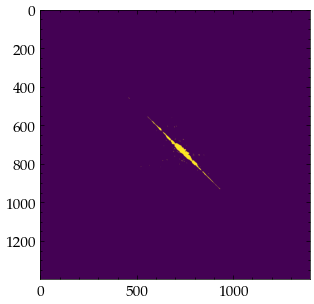

In [10]:
from matplotlib import pyplot as plt

img = np.zeros((grid_w, grid_h))

for x, y in newpos.values():
    img[x, y] = 1
plt.imshow(img)

In [ ]:
H.nodes(data=True)